In [1]:
'''This script demonstrates how to build a variational autoencoder
with Keras and deconvolution layers.
# Reference
- Auto-Encoding Variational Bayes
  https://arxiv.org/abs/1312.6114
'''
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
# number of convolutional filters to use
filters = 64
# convolution kernel size
num_conv = 3

batch_size = 100
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0
epochs = 5

In [4]:
x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

In [5]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

In [6]:
z = Lambda(sampling)([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(filters * 14 * 14, activation='relu')

if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, 14, 14)
else:
    output_shape = (batch_size, 14, 14, filters)

In [7]:
decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, 29, 29)
else:
    output_shape = (batch_size, 29, 29, filters)
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu')
decoder_mean_squash = Conv2D(img_chns,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

In [8]:
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 1)    5           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   320         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [9]:
# Compute VAE loss
xent_loss = img_rows * img_cols * metrics.binary_crossentropy(
    K.flatten(x),
    K.flatten(x_decoded_mean_squash))
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='rmsprop')
# vae.summary()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Output "conv2d_5" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_5" during training.
  if __name__ == '__main__':


In [25]:
# train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

In [26]:
x_train.shape

(60000, 28, 28)

In [27]:
x_train = x_train[:1000]

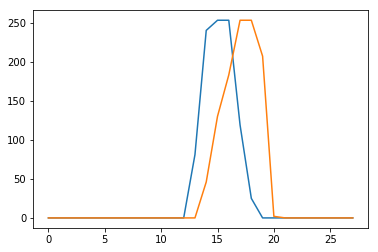

In [28]:
plt.plot(x_train[0,14])
plt.plot(x_train[0,18])

In [29]:
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)
print('x_train.shape:', x_train.shape)

x_train.shape: (1000, 28, 28, 1)


In [30]:
history = vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 1000 samples, validate on 10000 samples
Epoch 1/5
1000/1000 [==============================] - 28s 28ms/step - loss: 151.1277 - val_loss: 157.9596
Epoch 2/5
1000/1000 [==============================] - 27s 27ms/step - loss: 148.8629 - val_loss: 162.7612
Epoch 3/5
1000/1000 [==============================] - 27s 27ms/step - loss: 147.6131 - val_loss: 155.7050
Epoch 4/5
1000/1000 [==============================] - 27s 27ms/step - loss: 147.4814 - val_loss: 156.3217
Epoch 5/5
1000/1000 [==============================] - 27s 27ms/step - loss: 144.5456 - val_loss: 157.9581


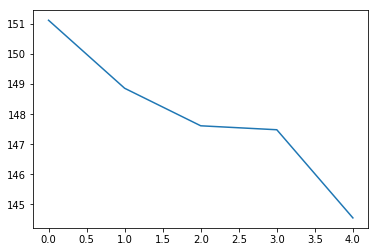

In [31]:
plt.plot(history.history['loss'])

In [32]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

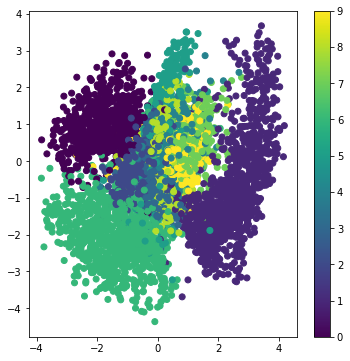

In [33]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [34]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

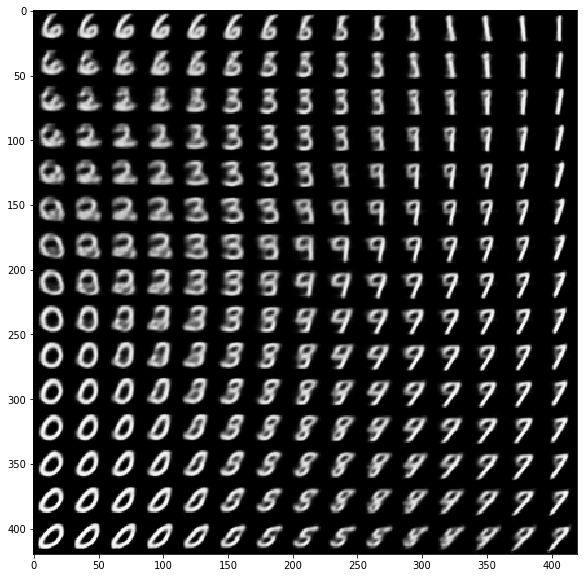

In [35]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()